In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio


In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


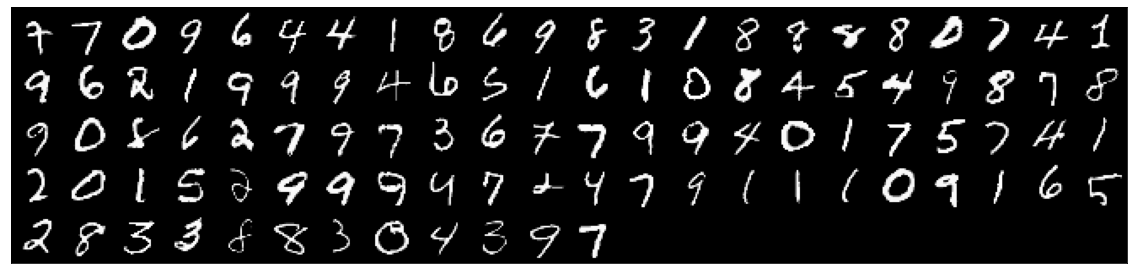

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
show_batch(trainloader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

In [ ]:
num_epochs = 250
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))
    
print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 4.28881598 d_loss: 0.61493433
Epoch 1: g_loss: 3.18285847 d_loss: 0.81273359
Epoch 2: g_loss: 2.65359759 d_loss: 0.67045408
Epoch 3: g_loss: 3.25395703 d_loss: 0.45565554
Epoch 4: g_loss: 3.30384541 d_loss: 0.42980799
Epoch 5: g_loss: 3.10226822 d_loss: 0.46786442
Epoch 6: g_loss: 2.78458548 d_loss: 0.54280901
Epoch 7: g_loss: 2.75181794 d_loss: 0.54050595
Epoch 8: g_loss: 2.56155443 d_loss: 0.57935297
Epoch 9: g_loss: 2.46769238 d_loss: 0.62335789
Epoch 10: g_loss: 2.28667068 d_loss: 0.66005188
Epoch 11: g_loss: 2.23463678 d_loss: 0.71634191
Epoch 12: g_loss: 2.18237901 d_loss: 0.73440939
Epoch 13: g_loss: 1.95475817 d_loss: 0.78855777
Epoch 14: g_loss: 1.89834416 d_loss: 0.83369547
Epoch 15: g_loss: 1.84511244 d_loss: 0.82356894
Epoch 16: g_loss: 1.78704536 d_loss: 0.84981620
Epoch 17: g_loss: 1.85393870 d_loss: 0.80606955
Epoch 18: g_loss: 1.78784764 d_loss: 0.86750865
Epoch 19: g_loss: 1.84315729 d_loss: 0.83471382
Epoch 20: g_loss: 1.77962983 d_loss: 0.85453832
Ep

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

In [ ]:
print(type(g_losses))
g_losses_T = torch.tensor(g_losses)
print(type(g_losses_T))

print(type(d_losses))
d_losses_T = torch.tensor(d_losses)
print(type(d_losses_T))

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


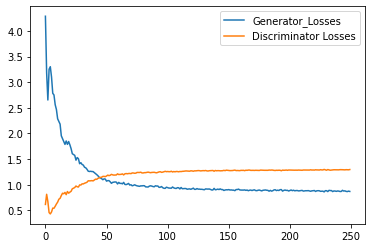

In [ ]:
plt.plot(g_losses_T, label='Generator_Losses')
plt.plot(d_losses_T, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

Descriminator loss decreased till 100th epoch and it starts increasing

Generator loss increased till 100th epoch and it become constant

Hence optimum number of epchoes is 100 without model over filtting

In [ ]:
print(g_losses[0])
print(g_losses[-1])

print(d_losses[0])
print(d_losses[-1])

tensor(4.2888, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8686, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6149, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2960, device='cuda:0', grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 242, 242])


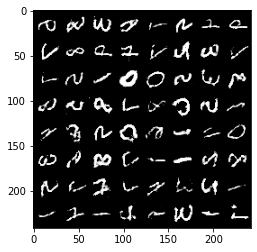

In [ ]:
print(type(images[0]))
print(images[0].shape)
plt.imshow(images[249].T)

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = noise(sample_size)


generator.eval()# eval mode
# generated samples
rand_images = generator(rand_z)
rand_images_T = rand_images.cpu().detach()
rand_z = rand_z.cpu().detach()
print(type(rand_images_T))


<class 'torch.Tensor'>


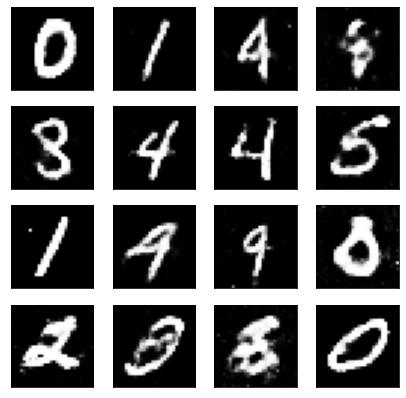

In [ ]:
view_samples(-1, [rand_images_T])